A notebook to test and demonstrate `KernelSteinTest`. This implements the kernelized Stein discrepancy test of Chwialkowski et al., 2016 and Liu et al., 2016 in ICML 2016.

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as ker
import kgof.util as util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

--------------

## Original implementation of Chwialkowski et al., 2016

In [15]:
from scipy.spatial.distance import squareform, pdist

def simulatepm(N, p_change):
    '''

    :param N:
    :param p_change:
    :return:
    '''
    X = np.zeros(N) - 1
    change_sign = np.random.rand(N) < p_change
    for i in range(N):
        if change_sign[i]:
            X[i] = -X[i - 1]
        else:
            X[i] = X[i - 1]
    return X


class _GoodnessOfFitTest:
    def __init__(self, grad_log_prob, scaling=1):
        #scaling is the sigma^2 as in exp(-|x_y|^2/2*sigma^2)
        self.scaling = scaling*2
        self.grad = grad_log_prob
        # construct (slow) multiple gradient handle if efficient one is not given
        

    def grad_multiple(self, X):
        #print self.grad
        return np.array([(self.grad)(x) for x in X])
    
    def kernel_matrix(self, X):

        # check for stupid mistake
        assert X.shape[0] > X.shape[1]

        sq_dists = squareform(pdist(X, 'sqeuclidean'))

        K = np.exp(-sq_dists/ self.scaling)
        return K

    def gradient_k_wrt_x(self, X, K, dim):

        X_dim = X[:, dim]
        assert X_dim.ndim == 1

        differences = X_dim.reshape(len(X_dim), 1) - X_dim.reshape(1, len(X_dim))

        return -2.0 / self.scaling * K * differences

    def gradient_k_wrt_y(self, X, K, dim):
        return -self.gradient_k_wrt_x(X, K, dim)

    def second_derivative_k(self, X, K, dim):
        X_dim = X[:, dim]
        assert X_dim.ndim == 1

        differences = X_dim.reshape(len(X_dim), 1) - X_dim.reshape(1, len(X_dim))

        sq_differences = differences ** 2

        return 2.0 * K * (self.scaling - 2 * sq_differences) / self.scaling ** 2

    def get_statistic_multiple_dim(self, samples, dim):
        num_samples = len(samples)

        log_pdf_gradients = self.grad_multiple(samples)
        # n x 1
        log_pdf_gradients = log_pdf_gradients[:, dim]
        # n x n
        K = self.kernel_matrix(samples)
        assert K.shape[0]==K.shape[1]
        # n x n
        gradient_k_x = self.gradient_k_wrt_x(samples, K, dim)
        assert gradient_k_x.shape[0] == gradient_k_x.shape[1]
        # n x n
        gradient_k_y = self.gradient_k_wrt_y(samples, K, dim)
        # n x n 
        second_derivative = self.second_derivative_k(samples, K, dim)
        assert second_derivative.shape[0] == second_derivative.shape[1]

        # use broadcasting to mimic the element wise looped call
        pairwise_log_gradients = log_pdf_gradients.reshape(num_samples, 1) \
                                 * log_pdf_gradients.reshape(1, num_samples)
        A = pairwise_log_gradients * K

        B = gradient_k_x * log_pdf_gradients
        C = (gradient_k_y.T * log_pdf_gradients).T
        D = second_derivative

        V_statistic = A + B + C + D
        #V_statistic =  C

        stat = num_samples * np.mean(V_statistic)
        return V_statistic, stat

    def compute_pvalues_for_processes(self, U_matrix, chane_prob, num_bootstrapped_stats=300):
        N = U_matrix.shape[0]
        bootsraped_stats = np.zeros(num_bootstrapped_stats)

        with util.NumpySeedContext(seed=10):
            for proc in range(num_bootstrapped_stats):
                # W = np.sign(orsetinW[:,proc])
                W = simulatepm(N, chane_prob)
                WW = np.outer(W, W)
                st = np.mean(U_matrix * WW)
                bootsraped_stats[proc] = N * st

        stat = N * np.mean(U_matrix)

        return float(np.sum(bootsraped_stats > stat)) / num_bootstrapped_stats

    def is_from_null(self, alpha, samples, chane_prob):
        dims = samples.shape[1]
        boots = 10 * int(dims / alpha)
        num_samples = samples.shape[0]
        U = np.zeros((num_samples, num_samples))
        for dim in range(dims):
            U2, _ = self.get_statistic_multiple_dim(samples, dim)
            U += U2

        p = self.compute_pvalues_for_processes(U, chane_prob, boots)
        return p, U
 


## Problem: p = Isotropic normal distribution

In [16]:
# true p
seed = 10
d = 10
mean = np.zeros(d)
variance = 1
isonorm = density.IsotropicNormal(mean, variance)

In [17]:
# sample
n = 500

# only one dimension of the mean is shifted
#draw_mean = mean + np.hstack((1, np.zeros(d-1)))
draw_mean = mean + 0
draw_variance = variance + 0
X = util.randn(n, d, seed=seed+2)*np.sqrt(draw_variance) + draw_mean
dat = data.Data(X)

In [18]:
# Test
alpha = 0.01

sig2 = util.meddistance(X, subsample=1000)**2
k = ker.KGauss(sig2)
#k = ker.KGauss(1)

bootstrapper = gof.bootstrapper_rademacher
kstein = gof.KernelSteinTest(isonorm, k, bootstrapper=bootstrapper, 
                             alpha=alpha, n_simulate=1100, seed=seed+1)

In [19]:
kstein_result = kstein.perform_test(dat, return_simulated_stats=True,
                                   return_ustat_gram=True)
kstein_result
#kstein.compute_stat(dat)

{'H': array([[ 16.01399712,   5.54193776,   0.40494693, ...,  -1.10777883,
          -3.37556566,  -2.3721604 ],
        [  5.54193776,   9.99810898,  -0.50465051, ...,  -1.78083321,
          -2.687318  ,  -1.44962531],
        [  0.40494693,  -0.50465051,  19.09687178, ...,   2.41903318,
           2.39100902,  -0.38761047],
        ..., 
        [ -1.10777883,  -1.78083321,   2.41903318, ...,  13.67256046,
           1.13541838,   0.92779199],
        [ -3.37556566,  -2.687318  ,   2.39100902, ...,   1.13541838,
          12.66859586,  -0.38957253],
        [ -2.3721604 ,  -1.44962531,  -0.38761047, ...,   0.92779199,
          -0.38957253,   7.97616692]]),
 'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 1100,
 'pvalue': 0.25363636363636366,
 'sim_stats': array([ 12.19051822,   8.96518034,   9.69914153, ...,   8.70767528,
          5.56164469,  10.94978822]),
 'test_stat': 12.13059039148277,
 'time_secs': 0.402083158493042}

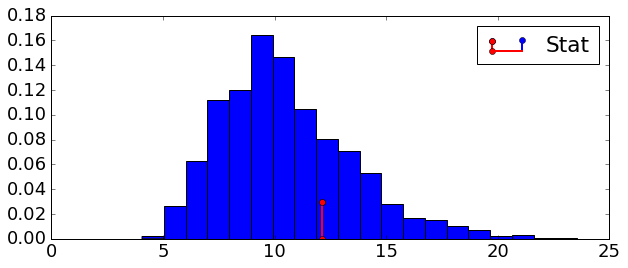

In [20]:
sim_stats = kstein_result['sim_stats']
plt.figure(figsize=(10, 4))
plt.hist(sim_stats, bins=20, normed=True);
plt.stem([kstein_result['test_stat']], [0.03], 'r-o', label='Stat')
plt.legend()

## Test original implementation

In [21]:
#sigma = np.array([[1, 0.2, 0.1], [0.2, 1, 0.4], [0.1, 0.4, 1]])
def grad_log_correleted(x):
    #sigmaInv = np.linalg.inv(sigma)
    #return - np.dot(sigmaInv.T + sigmaInv, x) / 2.0
    return -(x-mean)/variance

#me = _GoodnessOfFitTest(grad_log_correleted)

qm = _GoodnessOfFitTest(grad_log_correleted, scaling=sig2)
#X = np.random.multivariate_normal([0, 0, 0], sigma, 200)

p_val, U = qm.is_from_null(0.05, X, 0.1)
print(p_val)


0.247


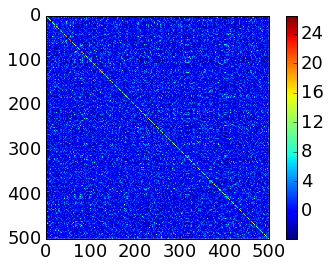

In [22]:
plt.imshow(U, interpolation='none')
plt.colorbar()

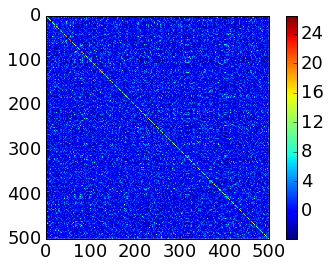

In [23]:
# U-statistic matrix from the new implementation
H = kstein_result['H']
plt.imshow(H, interpolation='none')
plt.colorbar()

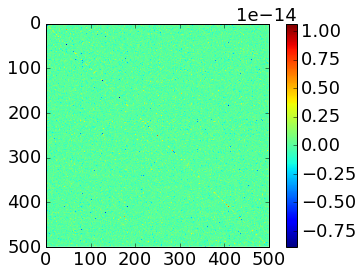

In [24]:
plt.imshow(U-H, interpolation='none')
plt.colorbar()